In [1]:
import cv2
import numpy as np
import rasterio
from rasterio import plot
import matplotlib.pyplot as plt
from matplotlib import pyplot
from utils import getXMPData, myImageSlicer

def save_new_band(path,reference_band,matrix):
    new_band = rasterio.open(path,'w',driver='Gtiff',
                          width=reference_band.width, 
                          height = reference_band.height, 
                          count=1, crs=reference_band.crs, 
                          transform=reference_band.transform, 
                          dtype='float64')
    new_band.write(matrix,1)
    new_band.close()

def printGrountTruth(filepath,image):
    with open(filepath, "r") as my_file:
        annotations_list = my_file.read().split('\n')
        print(annotations_list)

def get_band_combination(dataset_reader,combination_name='NDVI'):
    # Bands order at the raster file should be as ['Red','Green','Blue','RE','NIR']
    red = dataset_reader.read(1)
    green = dataset_reader.read(2)
    blue = dataset_reader.read(3)
    re = dataset_reader.read(4)
    nir = dataset_reader.read(5)
    band_combinations ={
        'NDVI': (np.where((nir+red)==0., 0, np.divide((nir-red),(nir+red)))),
        'GNDVI': (np.where((nir+green)==0., 0, (nir-green)/(nir+green))),
        'NDRE': (np.where((nir+re+red)==0., 0, (nir-re)/(nir+red))),
        'LCI': (np.where((nir+re)==0., 0, (nir-re)/(nir+re))),
        'OSAVI': (np.where((nir+red)==0., 0, 1.6*((nir-red)/(nir-red+0.16))))
    }
    return band_combinations[combination_name]
def normalize(x, lower, upper):
    """ This is a simple linear normalization for an array to a given bound interval

        Params:
        x: image that needs to be normalized in this case
        lower: (int) the lower limit of the interval
        upper: (int) the upper limit of the interval

        Return:
        x_norm: the normalized image between the specified interval 
    """
    x_max = np.max(x)
    x_min = np.min(x)
    # The slope of the linear normalization
    m = (upper - lower) / (x_max - x_min)
    # Linear function for the normalization
    x_norm = (m * (x - x_min)) + lower

    return x_norm
def drawMatrix(image,numOfRows, numOfColumns, widthCells, heightCells):
  i = 1
  while i<=numOfRows:
    j=1
    while j<=numOfColumns:
      cv2.rectangle(image, ((j*widthCells)-widthCells, (i*heightCells)-heightCells), ((j*widthCells), (i*heightCells)), (0, 0, 255), 2)
      j = j+1
    i = i+1
  return image

In [2]:
# Read reference image
image_path = 'datasets/mosaico/L301 B24_10m/L301_B24_10m.tif'

bands = ['Red','Green','Blue','RE','NIR']
image = rasterio.open(image_path)

In [5]:
print(type(image.read(1)))
print(image.read(1).shape)
print(image.count)
print(image.name)
print(image.bounds)
print(image.transform)
print(image.transform * (0, 0))
print(image.crs)
print(image.indexes)
print(image.read(1)[500:800])
red = image.read(1).astype('uint8')
green = image.read(2).astype('uint8')
blue = image.read(3).astype('uint8')
rgb = np.dstack((red,green,blue))
slicedMosaic = myImageSlicer(660,865,6600,8650,rgb)
print(type(slicedMosaic))

#fig = plt.figure(figsize=(18,12))
#plot.show(image)

<class 'numpy.ndarray'>
(8650, 6602)
4
datasets/mosaico/L301 B24_10m/L301_B24_10m.tif
BoundingBox(left=-84.94191945499072, bottom=10.797208320345788, right=-84.94161761821043, top=10.79759931446829)
| 0.00, 0.00,-84.94|
| 0.00,-0.00, 10.80|
| 0.00, 0.00, 1.00|
(-84.94191945499072, 10.79759931446829)
EPSG:4326
(1, 2, 3, 4)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
<class 'list'>


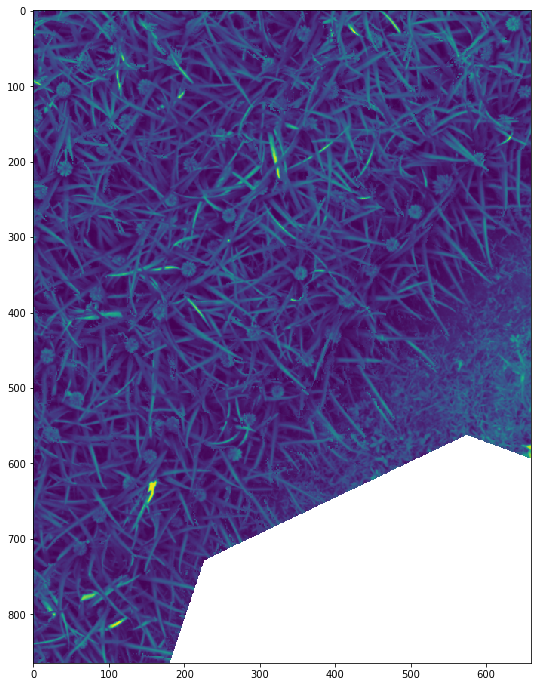

In [33]:
#cv2.imwrite('datasets/result/L301_B24_10m_6_6.jpg',slicedMosaic[6][6])
#fig = plt.figure(figsize=(12,12))
#plt.imshow(slicedMosaic[6][6])

red = rasterio.open('datasets/mosaico/L301 B24_10m/L301_B24_10m_Red.tif')
green = rasterio.open('datasets/mosaico/L301 B24_10m/L301_B24_10m_Green.tif')
blue = rasterio.open('datasets/mosaico/L301 B24_10m/L301_B24_10m_Blue.tif')
red = myImageSlicer(660,865,6600,8650,red.read(1))[6][6]
green = myImageSlicer(660,865,6600,8650,green.read(1))[6][6]
blue = myImageSlicer(660,865,6600,8650,blue.read(1))[6][6]
#rgb = np.dstack((red.read(1).astype('uint8'),green.read(1).astype('uint8'),blue.read(1).astype('uint8')))
rgb = np.dstack((red,green,blue))
fig = plt.figure(figsize=(12,12))
plot.show(green)

<class 'numpy.ndarray'>
uint8
(1300, 1600, 3)


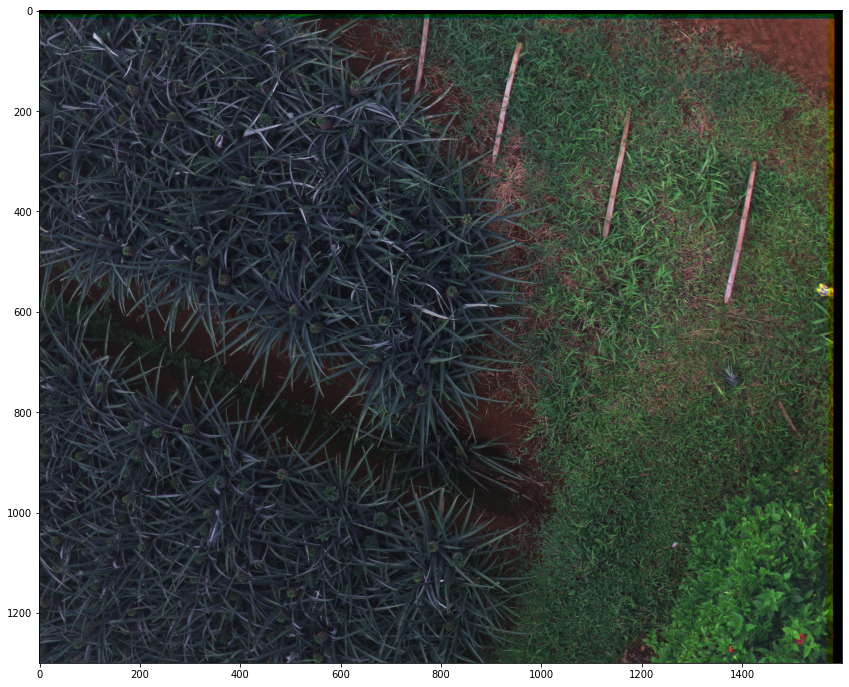

In [13]:
red = image.read(1).astype('uint8')
green = image.read(2).astype('uint8')
blue = image.read(3).astype('uint8')
rgb = np.dstack((red,green,blue))
print(type(rgb))
print(rgb.dtype)
print(rgb.shape)
#rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
fig = plt.figure(figsize=(18,12))
plt.imshow(rgb)

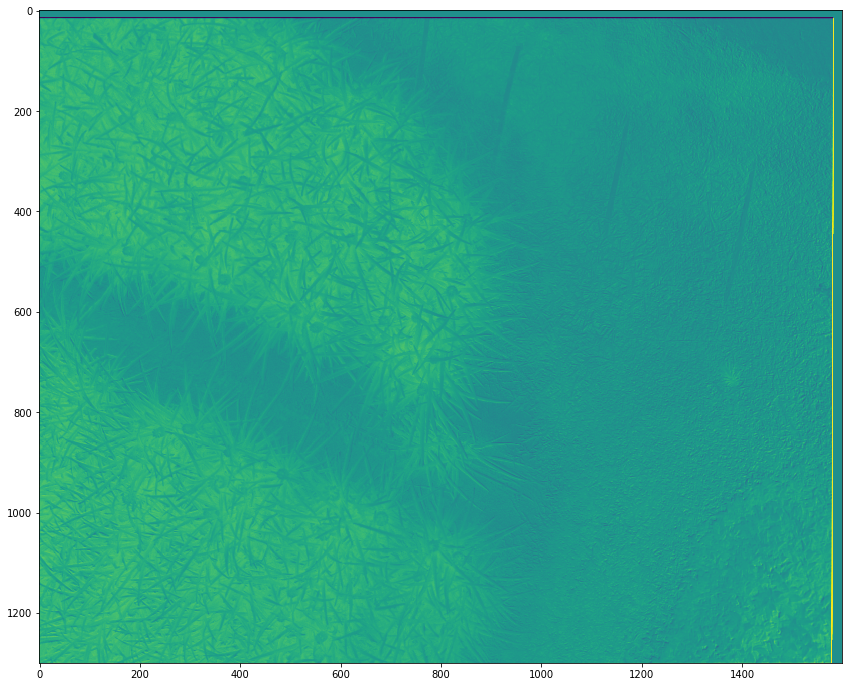

In [13]:
fig = plt.figure(figsize=(18,12))
plot.show(get_band_combination(image,'LCI'))

In [35]:
def files_to_array_yolov3(file_input_dir, class_file,img_extension):
    """
    Read files of annotations (yolo v3) and classes and returns the info into lists.
    Params
    :annotations_directory(str) path to annotations (format: yolo v3).
    :class_file(str) path to annotations (format: yolo v3).
    Returns
    :annotaions_result(list of tuples) format: [('image_name.jpg', [anno_1, anno_2]), ... , (...)]
    :class_file(list of classes) string list of the names of the classes.
    """
    class_list = []
    with open(class_file, "r") as my_file:
        #class_list = my_file.read().split('\n')
        for line in my_file.read().split('\n'):
            if len(line.strip()) > 1:
                class_list.append(line)

    myImages = [f for f in os.listdir(file_input_dir) if f.endswith(f'.{img_extension}')]
    
    annotations_names = []
    annotations_bboxes = []
    for file_image_name in myImages:
        img_path = file_input_dir + file_image_name
        imgRGB = cv2.imread(img_path)
        imageHeight, imageWidth, channels = imgRGB.shape
        yoloFile = open(img_path[:len(img_path)-4]+'.txt','r').readlines()
        
        annotations = []
        for label in yoloFile:
            label = label.split()
            xcenter = float(label[1]) * imageWidth
            ycenter = float(label[2]) * imageHeight
            bbox_width = float(label[3]) * imageWidth
            bbox_height = float(label[4]) * imageHeight
            x_top_left = int(abs(xcenter-(bbox_width/2)))
            y_top_left  = int(abs(ycenter - (bbox_height/2)))
            x_bottom_right = x_top_left + bbox_width
            y_bottom_right = y_top_left + bbox_height
            annotations.append(f'{x_top_left},{y_top_left},{x_bottom_right},{y_bottom_right},{label[0]}')
        annotations_names.append(file_image_name)
        annotations_bboxes.append(annotations)
    return annotations_names, annotations_bboxes, class_list

['L301_B24_10m_6_6.jpg']
uint8
(865, 660, 3)


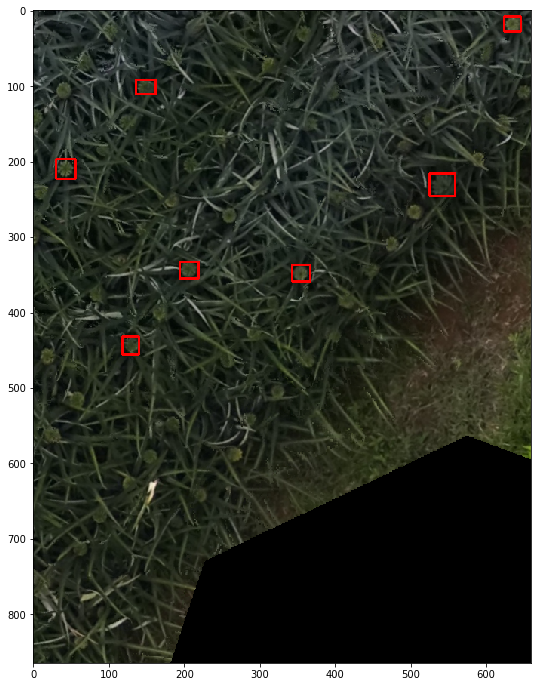

In [59]:
annotations_names, annotations_bboxes, class_list = files_to_array_yolov3('/home/manfred/workspace/multispectral-pineapple-detection/datasets/result/', '/home/manfred/workspace/multispectral-pineapple-detection/datasets/result/classes.txt','jpg')
print(annotations_names)
#rgb = cv2.imread('datasets/result/00000165.JPG')
#['Red','Green','Blue','RE','NIR']
#image = normalize(get_band_combination(rasterio.open('datasets/result/00000184.TIF'),combination_name='LCI'), 0, 255)
#image = cv2.imread('datasets/result/L301_B24_10m_6_6.jpg')
#image = rasterio.open('datasets/result/00000184.TIF').read(5)
#image = rasterio.open('datasets/result/L301_B24_10m_6_6.jpg').read(1)
#red = image.read(1).astype('uint8')
#green = image.read(2).astype('uint8')
#blue = image.read(3).astype('uint8')
#image = np.dstack((red,green,blue))
'''
red = rasterio.open('datasets/mosaico/L301 B24_10m/L301_B24_10m_Red.tif')
blue = myImageSlicer(660,865,6600,8650,blue.read(1))[6][6]
#rgb = np.dstack((red.read(1).astype('uint8'),green.read(1).astype('uint8'),blue.read(1).astype('uint8')))
rgb = np.dstack((red,green,blue))
image = red
'''
image = rasterio.open('datasets/mosaico/L301 B24_10m/L301_B24_10m.tif')
red = image.read(1)
green = image.read(2)
blue = image.read(3)
image = np.dstack((red,green,blue))
image = drawMatrix(image,10, 10, 660, 865)
'''image = myImageSlicer(660,865,6600,8650,image)[6][6]
print(image.dtype)
print(image.shape)
for line in annotations_bboxes[0]:
    line = line.split(',')
    image = cv2.rectangle(image, (int(float(line[0])), int(float(line[1]))), (int(float(line[2])), int(float(line[3]))), (255, 0, 0), 2)

#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#cv2.cvtColor(imReference, cv2.COLOR_RGB2GRAY)
fig = plt.figure(figsize=(18,12))
#plot.show(image)
plt.imshow(image)
#cv2.imwrite('datasets/result/L301_B24_10m_6_6_Green_GT.JPG',image)'''